In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import json

with open('data/pose_data.json', 'r') as file:
    pose_data = json.load(file)

In [5]:
first_frame = pose_data[0]["frame"]

In [6]:
def find_normalized_relative_vec(from_landmark, to_landmark, frame):
    frame_obj = pose_data[frame - first_frame]
    fromx = frame_obj["landmarks"][from_landmark][0]
    fromy = frame_obj["landmarks"][from_landmark][1]
    fromz = frame_obj["landmarks"][from_landmark][2]
    tox = frame_obj["landmarks"][to_landmark][0]
    toy = frame_obj["landmarks"][to_landmark][1]
    toz = frame_obj["landmarks"][to_landmark][2]
    relative_vec = [tox - fromx, toy-fromy, toz-fromz]
    relative_vec_norm = np.sqrt((relative_vec[0])**2 + (relative_vec[1])**2 + (relative_vec[2])**2)
    return [relative_vec[0] / relative_vec_norm, relative_vec[1] / relative_vec_norm,relative_vec[2] / relative_vec_norm]

In [34]:
# format is from: to
# some keys are repeated so i should probably fix that
REL_VEC_MAP = {
    "LEFT_WRIST": "LEFT_ELBOW",
    "LEFT_ELBOW": "LEFT_SHOULDER",
    "LEFT_SHOULDER": "RIGHT_SHOULDER",
    "RIGHT_WRIST": "RIGHT_ELBOW",
    "RIGHT_ELBOW": "RIGHT_SHOULDER",
    "LEFT_SHOULDER": "LEFT_HIP",
    "RIGHT_SHOULDER": "RIGHT_HIP",
    "LEFT_HIP": "RIGHT_HIP",
    "LEFT_HIP": "LEFT_KNEE",
    "LEFT_KNEE": "LEFT_ANKLE",
    "RIGHT_HIP": "RIGHT_KNEE",
    "RIGHT_KNEE": "RIGHT_ANKLE"
}

REL_VEC_TUPS = (
    ("LEFT_WRIST", "LEFT_ELBOW"),
    ("LEFT_ELBOW", "LEFT_SHOULDER"),
    ("LEFT_SHOULDER", "RIGHT_SHOULDER"),
    ("RIGHT_WRIST", "RIGHT_ELBOW"),
    ("RIGHT_ELBOW", "RIGHT_SHOULDER"),
    ("LEFT_SHOULDER", "LEFT_HIP"),
    ("RIGHT_SHOULDER", "RIGHT_HIP"),
    ("LEFT_HIP", "RIGHT_HIP"),
    ("LEFT_HIP", "LEFT_KNEE"),
    ("LEFT_KNEE", "LEFT_ANKLE"),
    ("RIGHT_HIP", "RIGHT_KNEE"),
    ("RIGHT_KNEE", "RIGHT_ANKLE")
)

91.66346175678247

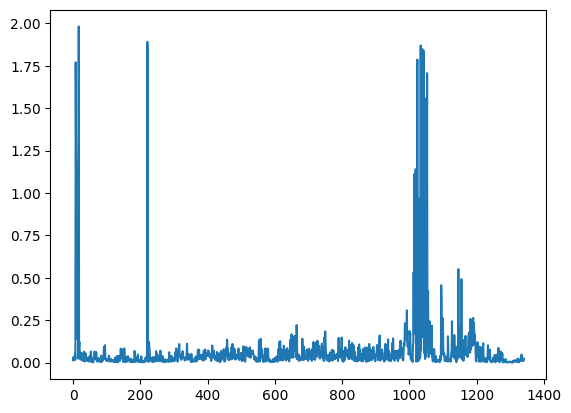

In [30]:
diffs = []

from_joint = "LEFT_SHOULDER"
to_joint = "RIGHT_SHOULDER"

for i in range(1, len(pose_data)):
    first_normed_rel_vec = find_normalized_relative_vec(from_joint, to_joint, i-1)
    second_normed_rel_vec = find_normalized_relative_vec(from_joint, to_joint, i)
    diff_norm = np.linalg.norm(np.array(second_normed_rel_vec) - np.array(first_normed_rel_vec))
    diffs.append(diff_norm)

plt.plot(diffs)
sum(diffs)


198.46508077581228

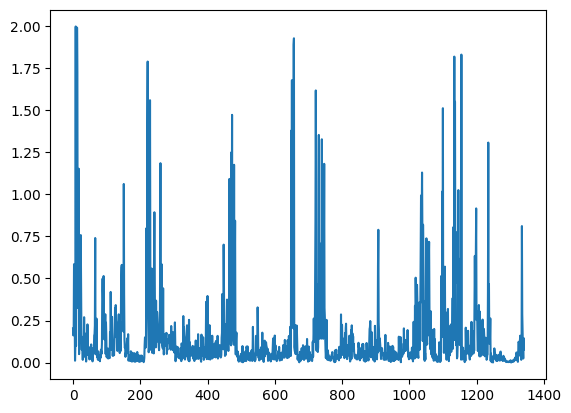

In [33]:
diffs = []

from_joint = "LEFT_WRIST"
to_joint = "LEFT_ELBOW"

for i in range(1, len(pose_data)):
    first_normed_rel_vec = find_normalized_relative_vec(from_joint, to_joint, i-1)
    second_normed_rel_vec = find_normalized_relative_vec(from_joint, to_joint, i)
    diff_norm = np.linalg.norm(np.array(second_normed_rel_vec) - np.array(first_normed_rel_vec))
    diffs.append(diff_norm)

plt.plot(diffs)
sum(diffs)

In [45]:
def find_normalized_relative_vec_from_obj(from_landmark, to_landmark, frame_obj):
    fromx = frame_obj["landmarks"][from_landmark][0]
    fromy = frame_obj["landmarks"][from_landmark][1]
    fromz = frame_obj["landmarks"][from_landmark][2]
    tox = frame_obj["landmarks"][to_landmark][0]
    toy = frame_obj["landmarks"][to_landmark][1]
    toz = frame_obj["landmarks"][to_landmark][2]
    relative_vec = [tox - fromx, toy-fromy, toz-fromz]
    relative_vec_norm = np.sqrt((relative_vec[0])**2 + (relative_vec[1])**2 + (relative_vec[2])**2)
    return [relative_vec[0] / relative_vec_norm, relative_vec[1] / relative_vec_norm,relative_vec[2] / relative_vec_norm]

def find_sim(template_frame, user_frame, weights):
    sims = [] #form at is (from_joint, to_joint, difference)
    pure_sims_array = []
    for rel_vec in REL_VEC_TUPS:
        user_vec = find_normalized_relative_vec_from_obj(rel_vec[0], rel_vec[1], template_frame)
        temp_vec = find_normalized_relative_vec_from_obj(rel_vec[0], rel_vec[1], user_frame)
        diff_dot = np.dot(np.array(user_vec), np.array(temp_vec))
        sims.append((rel_vec[0], rel_vec[1], diff_dot))
        pure_sims_array.append(diff_dot)
    
    dot_product = np.dot(pure_sims_array, weights)
    return dot_product, sims
    

In [55]:
find_sim(pose_data[0], pose_data[500], np.ones(12))

(-8.624606744179893,
 [('LEFT_WRIST', 'LEFT_ELBOW', -0.815403072392837),
  ('LEFT_ELBOW', 'LEFT_SHOULDER', -0.9995361262743439),
  ('LEFT_SHOULDER', 'RIGHT_SHOULDER', -0.7325297300639042),
  ('RIGHT_WRIST', 'RIGHT_ELBOW', 0.34935880922389406),
  ('RIGHT_ELBOW', 'RIGHT_SHOULDER', -0.8821872588186506),
  ('LEFT_SHOULDER', 'LEFT_HIP', -0.9283975084535369),
  ('RIGHT_SHOULDER', 'RIGHT_HIP', -0.9930669289164149),
  ('LEFT_HIP', 'RIGHT_HIP', -0.8937106808669377),
  ('LEFT_HIP', 'LEFT_KNEE', -0.713501151110973),
  ('LEFT_KNEE', 'LEFT_ANKLE', -0.6408174453603425),
  ('RIGHT_HIP', 'RIGHT_KNEE', -0.8898351421811745),
  ('RIGHT_KNEE', 'RIGHT_ANKLE', -0.48498050896467126)])

In [50]:
def find_weights(pose_data):
    weights = []
    for rel_vec in REL_VEC_TUPS:
        diffs = []

        from_joint = rel_vec[0]
        to_joint = rel_vec[1]

        for i in range(1, len(pose_data)):
            first_normed_rel_vec = find_normalized_relative_vec(from_joint, to_joint, i-1)
            second_normed_rel_vec = find_normalized_relative_vec(from_joint, to_joint, i)
            diff_norm = np.linalg.norm(np.array(second_normed_rel_vec) - np.array(first_normed_rel_vec))
            diffs.append(diff_norm)

        weights.append(sum(diffs))
    return weights

In [51]:
find_weights(pose_data)

[198.46508077581228,
 125.43708929779562,
 91.66346175678247,
 239.97919899852755,
 118.23686355896996,
 44.0539612496253,
 40.641522463771054,
 72.76329052358817,
 65.48157918863932,
 80.79326536260257,
 83.66969215486853,
 72.74304458691327]

In [52]:
REL_VEC_TUPS

(('LEFT_WRIST', 'LEFT_ELBOW'),
 ('LEFT_ELBOW', 'LEFT_SHOULDER'),
 ('LEFT_SHOULDER', 'RIGHT_SHOULDER'),
 ('RIGHT_WRIST', 'RIGHT_ELBOW'),
 ('RIGHT_ELBOW', 'RIGHT_SHOULDER'),
 ('LEFT_SHOULDER', 'LEFT_HIP'),
 ('RIGHT_SHOULDER', 'RIGHT_HIP'),
 ('LEFT_HIP', 'RIGHT_HIP'),
 ('LEFT_HIP', 'LEFT_KNEE'),
 ('LEFT_KNEE', 'LEFT_ANKLE'),
 ('RIGHT_HIP', 'RIGHT_KNEE'),
 ('RIGHT_KNEE', 'RIGHT_ANKLE'))

In [56]:
pose_data

[{'frame': 9,
  'timestamp': 0.3,
  'landmarks': {'LEFT_SHOULDER': [-0.0538150817155838,
    -0.40668174624443054,
    -0.0010098423808813095],
   'RIGHT_SHOULDER': [0.06761525571346283,
    -0.438326895236969,
    -0.12065804749727249],
   'LEFT_ELBOW': [-0.09174469113349915,
    -0.21799346804618835,
    0.048474568873643875],
   'RIGHT_ELBOW': [0.04949960485100746,
    -0.19054462015628815,
    -0.07878579944372177],
   'LEFT_WRIST': [-0.012535757385194302,
    -0.059257909655570984,
    0.015306593850255013],
   'RIGHT_WRIST': [0.07879286259412766,
    -0.0667775347828865,
    -0.01587270013988018],
   'LEFT_HIP': [-0.046174339950084686,
    -0.004013223573565483,
    -0.003438046434894204],
   'RIGHT_HIP': [0.043879080563783646,
    -0.002347144763916731,
    0.0019455932779237628],
   'LEFT_KNEE': [0.11658654361963272, 0.17597009241580963, 0.0997520387172699],
   'RIGHT_KNEE': [0.06728212535381317,
    0.12544633448123932,
    0.07865854352712631],
   'LEFT_ANKLE': [0.21305391192

In [ ]:
def fill_values(template_pose_data, user_pose_data):
    all_timestamps_ordered = [-1]
    num_points_temp = len(template_pose_data)
    num_points_user = len(user_pose_data)
    temp_pointer = 0
    user_pointer = 0
    while True:
        try:
            curr_temp = template_pose_data[temp_pointer]["timestamp"]
            curr_user = user_pose_data[user_pointer]["timestamp"]
        except:
            break

        if temp_pointer >= num_points_temp and all_timestamps_ordered[-1]:
            if user_pointer >= num_points_user:
                break
            if all_timestamps_ordered[-1] != curr_user:
                all_timestamps_ordered.append(curr_user)
            user_pointer += 1
        elif user_pointer >= num_points_user:
            if all_timestamps_ordered[-1] != curr_temp:
                all_timestamps_ordered.append(curr_temp)
            temp_pointer += 1                        
        elif curr_temp < curr_user:
            if all_timestamps_ordered[-1] != curr_temp:
                all_timestamps_ordered.append(curr_temp)
            temp_pointer += 1
        else: 
            if all_timestamps_ordered[-1] != curr_user:
                all_timestamps_ordered.append(curr_user)
            user_pointer += 1

    # EVERYTHING AFTER THIS IS COPILOTED
    
    all_timestamps_ordered = all_timestamps_ordered[1:]
    interpolated_template_data = []
    for timestamp in all_timestamps_ordered:
        matching_elements = [data for data in template_pose_data if data["timestamp"] == timestamp]
        if matching_elements:
            interpolated_template_data.append(matching_elements[0])
        else:
            # Find the two closest points
            earlier_points = [data for data in template_pose_data if data["timestamp"] < timestamp]
            later_points = [data for data in template_pose_data if data["timestamp"] > timestamp]
            
            if earlier_points and later_points:
                earlier_point = max(earlier_points, key=lambda x: x["timestamp"])
                later_point = min(later_points, key=lambda x: x["timestamp"])
                
                # Linear interpolation
                ratio = (timestamp - earlier_point["timestamp"]) / (later_point["timestamp"] - earlier_point["timestamp"])
                interpolated_landmarks = {
                    key: [
                        earlier_point["landmarks"][key][i] + ratio * (later_point["landmarks"][key][i] - earlier_point["landmarks"][key][i])
                        for i in range(3)
                    ]
                    for key in earlier_point["landmarks"]
                }
                interpolated_template_data.append({"timestamp": timestamp, "landmarks": interpolated_landmarks})
            elif earlier_points:
                interpolated_template_data.append(max(earlier_points, key=lambda x: x["timestamp"]))
            elif later_points:
                interpolated_template_data.append(min(later_points, key=lambda x: x["timestamp"]))
    
    return interpolated_template_data
        

In [71]:
fill_values(pose_data, pose_data)

[{'frame': 9,
  'timestamp': 0.3,
  'landmarks': {'LEFT_SHOULDER': [-0.0538150817155838,
    -0.40668174624443054,
    -0.0010098423808813095],
   'RIGHT_SHOULDER': [0.06761525571346283,
    -0.438326895236969,
    -0.12065804749727249],
   'LEFT_ELBOW': [-0.09174469113349915,
    -0.21799346804618835,
    0.048474568873643875],
   'RIGHT_ELBOW': [0.04949960485100746,
    -0.19054462015628815,
    -0.07878579944372177],
   'LEFT_WRIST': [-0.012535757385194302,
    -0.059257909655570984,
    0.015306593850255013],
   'RIGHT_WRIST': [0.07879286259412766,
    -0.0667775347828865,
    -0.01587270013988018],
   'LEFT_HIP': [-0.046174339950084686,
    -0.004013223573565483,
    -0.003438046434894204],
   'RIGHT_HIP': [0.043879080563783646,
    -0.002347144763916731,
    0.0019455932779237628],
   'LEFT_KNEE': [0.11658654361963272, 0.17597009241580963, 0.0997520387172699],
   'RIGHT_KNEE': [0.06728212535381317,
    0.12544633448123932,
    0.07865854352712631],
   'LEFT_ANKLE': [0.21305391192